# Hosted Copies, Targeted Updates

## An Alternative, Efficient ETL Strategy with Python

![ILGISA 2022 GitHub Repo QR](../images/ilgisa-2022-qr.png)

# https://github.com/jdcarls2/ilgisa-2022

Two things to note at the top:
1. Slides and various files are available at the GitHub repo linked here.
2. This is **not** a Python workshop! See the repo if you want all the gorey details, but in the interest of time, I won't necessarily be explaining everything in great detail.

# Outline

1. What's a "hosted copy"?
2. Common Approaches
3. The Process
4. Discussion
5. Questions?

# What is a "hosted copy", anyway?

## A Common Problem

An organization (say, a county) has datasets that they wish to make available to the public.

*However!*

The authoritative source(s) is/are:
- Not available to register with ArcGIS Server
- Too sensitive to expose outside your organization's network
- Not in the same place (i.e., a SQL view layer is not possible)

A prime example of this would be CAMA data. The geographic element comes from our own GIS layers, but the rest of the data comes from multiple tables across a database and file-based data sources, all of which need to be harmonized together.

## A Common Solution

The organization publishes a "hosted copy" of the data to ArcGIS Online / Portal. The data is loaded into ArcGIS Datastore and served from there.

Now the public can see and interact with the dataset, but the authoritative source remains inaccessible to the rest of the internet. All is well!

## A New Problem!

Suppose the organization's authoritative source is *dynamic*.

How can updates be passed to the hosted layer to ensure that the public sees the most current information?

# Common Approaches

## Overwriting Your Service

**Don't do this!**

When you overwrite a service (*usually done from your desktop software or via `arcpy`*), literally **everything** about the service is wiped out and re-created except for the portal ItemID and the service URL.

**It's like bulldozing your house so you can re-paint the kitchen.**

### When does it make sense?

With hosted layers, this process is necessary if your service:
- Has changed the order / number of its layers
- Has changes to relationship classes

Still, you may be better off making a brand new layer.

### When does it *not* make sense?

- Schema alterations
- Upated features or attributes
- Default symbology / label / popup changes

Portal & AGOL have built-in ways to manage *all* of these. You're much better off making parallel changes to your hosted layer than burning it down.

## Truncate / Append

This method leaves the layer and its schema intact and simply *empties* the layer of all its data, then loads in a fresh set.

In keeping with the house analogy, this is less drastic than bulldozing. It's more like moving all your furniture out of the house, replacing a chair, then putting it all back.

It's a *much* safer approach.

# Targeted Updates

## What's different about this method?

- Compares source / destination data and specifically identifies "stale" rows
- Identifies adds / deletes
- Passes data directly into the destination layer without a separate upload / layer needing to be created
- Can run *per source* on a subset of fields

![Diagram of the merge / append model](../images/join-append.png)

![Direct Edit model](../images/direct-edit.png)

## Key Benefits

Even very large datasets can be refreshed in only a few minutes.

We have a parcel layer with about 50,000 active parcels in it. On an ordinary day, maybe 300 or so parcels see some kind of relevant change to owner, address, assessment, etc. These updates take *seconds* to perform.

Recently, we published the 2022 assessments, and our Supervisor of Assessments requested that the web layer reflect the new assessment numbers. This caused about 48,000 parcels to need a few attributes updated. (Some parcels' assessments did not change from 2021 to 2022, hence the gap.)

This update of essentially every parcel in the layer successfully completed in under 3 minutes.

There is *never* a moment when the layer is unresponsive or emptied of its data.

That's important because it means these sorts of updates can happen at *any time*, and your end users won't even know it's happening.

In the earlier example of the 48,000 parcels updating? That was done *in the middle of the day*.

In fact, there's no reason some of these processes couldn't happen multiple times a day. The lag time between a change being made in the assessments database and it showing up on the map could be measured in *minutes*, if I felt like scheduling the script to run that often.

Total server traffic and server-side processing is dramatically diminished.

Probably goes without saying, but anything you can do to reduce the workload on your Server machine is a good thing.

## Requirements

- Environment
    - ArcGIS Python API
    - Access to source data
    - Portal / AGOL authentication

- Non-Spatial Data Layers
    - Shared primary key between source(s) and destination
- Spatial Data Layers
    - Editor Tracking Timestamps
    - GloablID and GUID field on source and destination, respectively

# The Process: Prep Work

<Item title:"Parcels_ILGISA_Demo" type:Feature Layer Collection owner:carlsonj9>
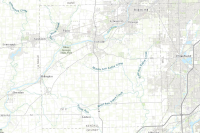

In [48]:
# Required Modules
from arcgis.gis import GIS
from arcgis.features import GeoAccessor
import pandas as pd

# Connect to AGOL
gis = GIS(profile='AGOL')

# Get Destination Layer
dest = gis.content.get('5ab5004c86f341278c6b1d996e551cb4')

dest

## Pulling Source Data

### From Spatial File

In [70]:
p_df = GeoAccessor.from_featureclass('../data-files/ilgisa.gdb/parcels')

p_df.head()

,Shape_Length,Shape_Area,GlobalID,pin,created_user,created_date,last_edited_user,last_edited_date,SHAPE
0,5276.864891,1.100042e+06,{31FD8039-5E6A-4668-B4A0-037CF22F4451},01-06-100-001,JCARLSON,2022-10-12T03:03:49+00:00,JCARLSON,2022-10-12T03:03:49+00:00,"{""rings"": [[[910927.6100513302, 1838427.720154..."
1,1933.037037,2.192212e+05,{064B7505-4399-4DA3-91AA-1048943A82DB},01-06-100-014,JCARLSON,2022-10-12T03:03:49+00:00,JCARLSON,2022-10-12T03:03:49+00:00,"{""rings"": [[[913069.6894285791, 1838405.293033..."
2,2958.945676,4.981201e+05,{9E897663-5DC9-4F8B-ACB1-DB29CFBA0A26},01-06-200-002,JCARLSON,2022-10-12T03:03:49+00:00,JCARLSON,2022-10-12T03:03:49+00:00,"{""rings"": [[[914855.5198464133, 1839151.150137..."
3,7990.099714,3.220557e+06,{0D0B143F-C3ED-4AFD-B5E1-968977CFB693},01-06-200-012,JCARLSON,2022-10-12T03:03:49+00:00,JCARLSON,2022-10-12T03:03:49+00:00,"{""rings"": [[[915239.6099574938, 1840128.820098..."
4,1308.180869,1.064012e+05,{7E0DBA9F-5804-4DBD-A808-17DADD359C3C},01-06-300-004,JCARLSON,2022-10-12T03:03:49+00:00,JCARLSON,2022-10-12T03:03:49+00:00,"{""rings"": [[[914016.6399624944, 1836439.480036..."


### From Non-Spatial Files

In [107]:
a_df = pd.read_excel('../data-files/assessments.xlsx')

a_df.rename(columns={'parcel_number':'pin'}, inplace=True)

a_df.set_index('pin', inplace=True, drop=False)

a_df.head()

,pin,property_class,assessed_value,owner_name,tax_code
pin,,,,,
01-06-100-001,01-06-100-001,40,39603,Tylor Y Mercado,LR001
01-06-100-014,01-06-100-014,11,47075,Johnathon R Corbett,LR001
01-06-200-002,01-06-200-002,21,14216,Odalys Hope,NaN
01-06-200-012,01-06-200-012,21,2660,Giavanna J Richmond,NaN
01-06-300-004,01-06-300-004,11,86255,Matthias Gallant,LR001


In [108]:
s_df = pd.read_csv('../data-files/structures.csv').set_index('pin', drop=False)

s_df.head()

,pin,structure_type,description,sq_ft,beds,baths,h_baths,primary_yn
pin,,,,,,,,
01-06-100-001,01-06-100-001,1 story,NaN,1250,2.0,1.0,1.0,y
01-06-100-014,01-06-100-014,2 story,NaN,2200,4.0,2.0,1.0,y
01-06-300-004,01-06-300-004,2 story,NaN,2100,5.0,3.0,0.0,y
01-06-300-004,01-06-300-004,other,pole barn,3000,NaN,NaN,NaN,n
01-06-300-004,01-06-300-004,other,shed,350,NaN,NaN,NaN,n


# The Process: Comparisons

## Assessment Data

### Reshape Data

For an accurate comparison, we need our frames to be the same *shape*. We will do this by:
1. Only looking at destination columns in common with the source
1. Only including rows common to both

In [110]:
# Query destination, no shapes, subset of fields
dest_a = dest.layers[0].query(
    out_fields=a_df.columns.to_list(),
    as_df=True,
    return_geometry=False
).set_index('pin', drop=False)

dest_a.head()

,OBJECTID,pin,property_class,assessed_value,owner_name,tax_code
pin,,,,,,
01-06-100-001,2,01-06-100-001,None,0,None,None
01-06-100-014,3,01-06-100-014,None,0,None,None
01-06-200-002,4,01-06-200-002,None,0,None,None
01-06-200-012,5,01-06-200-012,None,0,None,None
01-06-300-004,6,01-06-300-004,None,0,None,None


So there we have our destination layer, but just the fields we need, and no geometry.

In [112]:
inner_a = a_df.merge(dest_a[['OBJECTID']], how='inner', left_index=True, right_index=True)

In [114]:
inner_a.head()

,pin,property_class,assessed_value,owner_name,tax_code,OBJECTID
pin,,,,,,
01-06-100-001,01-06-100-001,40,39603,Tylor Y Mercado,LR001,2
01-06-100-014,01-06-100-014,11,47075,Johnathon R Corbett,LR001,3
01-06-200-002,01-06-200-002,21,14216,Odalys Hope,NaN,4
01-06-200-012,01-06-200-012,21,2660,Giavanna J Richmond,NaN,5
01-06-300-004,01-06-300-004,11,86255,Matthias Gallant,LR001,6


Note here that by merging our frames using the `inner` method and subsetting the `OBJECTID` column of the destination, what we end up with here is our assessment data together with the corresponding OBJECTID in the destination. We can now use this to compare frames.

In [120]:
# Sort frames the same, just in case
for df in [inner_a, dest_a]:
    df.sort_index(inplace=True)
    
# Get columns in same order
dest_a = dest_a[inner_a.columns.to_list()]

In [122]:
comp_a = inner_a.compare(dest_a[dest_a.index.isin(inner_a.index.to_list())])

comp_a

property_class       assessed_value                 owner_name  \
                        self other           self other                 self   
pin                                                                            
01-06-100-001             40  None          39603     0      Tylor Y Mercado   
01-06-100-003             30  None          33296     0   Carolina J Winston   
01-06-100-004             11  None          13355     0      Berenice Prieto   
01-06-100-005             30  None          88728     0    Wayne V Whitworth   
01-06-100-006             11  None          42899     0       Bryce C Davies   
01-06-100-011             11  None          59261     0       Malcolm E Eddy   
01-06-100-012             21  None          90056     0        Morris C Pyle   
01-06-100-013             40  None          94967     0       Felipe K Wolfe   
01-06-100-014             11  None          47075     0  Johnathon R Corbett   
01-06-100-015             21  None          33494     0    Zackary J Diamond   
01-06-100-016             40  None           6544     0      Adrian Z Feeney   
01-06-200-002             21  None          14216     0          Odalys Hope   
01-06-200-003             30  None          66988     0     Taniya G Stearns   
01-06-200-004             40  None          74178     0      Maegan D Carson   
01-06-200-012             21  None           2660     0  Giavanna J Richmond   
01-06-300-002             21  None          68782     0         Kade S Heath   
01-06-300-004             11  None          86255     0     Matthias Gallant   
01-06-300-005             21  None          31039     0          Zain Lanier   
01-06-300-006             30  None          50060     0     Leonard Lipscomb   
01-06-400-002             11  None          43455     0        Ira Benavidez   
01-06-400-003             21  None          24986     0  Aidan G Fitzpatrick   
01-07-100-002             21  None          81918     0        Dawn K Loomis   
01-07-100-003             11  None          70555     0     Collin Rasmussen   
01-07-200-004             11  None          22805     0        Hollie Meador   
01-07-200-005             40  None          42975     0     Jerrod Castaneda   
01-07-200-006             40  None          44874     0       Jane J Whitman   
01-07-200-007             21  None          14094     0       Caitlynn Alley   
01-07-200-008             11  None          87618     0        Ayanna McNeil   
01-07-200-009             40  None           4192     0      Lorenzo H Glass   

                    tax_code        
              other     self other  
pin                                 
01-06-100-001  None    LR001  None  
01-06-100-003  None      NaN  None  
01-06-100-004  None    LR001  None  
01-06-100-005  None      NaN  None  
01-06-100-006  None    LR001  None  
01-06-100-011  None    LR003  None  
01-06-100-012  None      NaN  None  
01-06-100-013  None    LR001  None  
01-06-100-014  None    LR001  None  
01-06-100-015  None      NaN  None  
01-06-100-016  None    LR001  None  
01-06-200-002  None      NaN  None  
01-06-200-003  None      NaN  None  
01-06-200-004  None    LR003  None  
01-06-200-012  None      NaN  None  
01-06-300-002  None      NaN  None  
01-06-300-004  None    LR001  None  
01-06-300-005  None      NaN  None  
01-06-300-006  None      NaN  None  
01-06-400-002  None    LR003  None  
01-06-400-003  None      NaN  None  
01-07-100-002  None      NaN  None  
01-07-100-003  None    LR003  None  
01-07-200-004  None    LR003  None  
01-07-200-005  None    LR001  None  
01-07-200-006  None    LR003  None  
01-07-200-007  None      NaN  None  
01-07-200-008  None    LR003  None  
01-07-200-009  None    LR003  None

In [124]:
update_a = inner_a[inner_a.index.isin(comp_a.index.to_list())]

update_a

,pin,property_class,assessed_value,owner_name,tax_code,OBJECTID
pin,,,,,,
01-06-100-001,01-06-100-001,40,39603,Tylor Y Mercado,LR001,2
01-06-100-003,01-06-100-003,30,33296,Carolina J Winston,NaN,8
01-06-100-004,01-06-100-004,11,13355,Berenice Prieto,LR001,13
01-06-100-005,01-06-100-005,30,88728,Wayne V Whitworth,NaN,9
01-06-100-006,01-06-100-006,11,42899,Bryce C Davies,LR001,11
01-06-100-011,01-06-100-011,11,59261,Malcolm E Eddy,LR003,16
01-06-100-012,01-06-100-012,21,90056,Morris C Pyle,NaN,30
01-06-100-013,01-06-100-013,40,94967,Felipe K Wolfe,LR001,15
01-06-100-014,01-06-100-014,11,47075,Johnathon R Corbett,LR001,3


In [125]:
dest.layers[0].edit_features(updates=update_a.spatial.to_featureset())

{'addResults': [],
 'updateResults': [{'objectId': 2,
   'uniqueId': 2,
   'globalId': None,
   'success': True},
  {'objectId': 8, 'uniqueId': 8, 'globalId': None, 'success': True},
  {'objectId': 13, 'uniqueId': 13, 'globalId': None, 'success': True},
  {'objectId': 9, 'uniqueId': 9, 'globalId': None, 'success': True},
  {'objectId': 11, 'uniqueId': 11, 'globalId': None, 'success': True},
  {'objectId': 16, 'uniqueId': 16, 'globalId': None, 'success': True},
  {'objectId': 30, 'uniqueId': 30, 'globalId': None, 'success': True},
  {'objectId': 15, 'uniqueId': 15, 'globalId': None, 'success': True},
  {'objectId': 3, 'uniqueId': 3, 'globalId': None, 'success': True},
  {'objectId': 14, 'uniqueId': 14, 'globalId': None, 'success': True},
  {'objectId': 10, 'uniqueId': 10, 'globalId': None, 'success': True},
  {'objectId': 4, 'uniqueId': 4, 'globalId': None, 'success': True},
  {'objectId': 22, 'uniqueId': 22, 'globalId': None, 'success': True},
  {'objectId': 23, 'uniqueId': 23, 'global

## Use Comparisons to Subset Source

## Supply Source Data as Edits

In [ ]:
### here's the assessments data update script for copying stuff

## Packages
import os
import sys
import time
import pandas as pd
import admintoolbox.portal_functions as f

## Start Counter
start_time = time.perf_counter()


## Portal and Layers
# Portal connection
gis = f.setPortal('Assessment Data Update')

# Parcels
parcels = gis.content.get('647e966722f943d0b5d49f82288a839e').layers[1]

# Devnet connection string
devnet_constr = 'mssql+pymssql://172.18.1.23/Property_Tax'

# Logging origin
origin = 'Assessment Data Update'


## Script body
# Query Devnet
with open(os.path.join(sys.path[0], 'assessment.sql'), mode='r') as q:
    assessment_query = q.read()

parcel_df = pd.read_sql_query(assessment_query, devnet_constr)

# Group rows by PIN
parcel_df = parcel_df.groupby(by='pin').first()

## Clean up Devnet rows
# Strip excess whitespace from address and ownership fields resulted from concatenating null 
parcel_df.replace(regex={r'\s\s+' : ' ', r'^\s+' : '', r'\s+$' : '', '<|>':''}, inplace=True)

# Set NaN to 0 in numeric fields
i_fields = [
    'tax_billed',
    'farm_land',
    'farm_building',
    'non_farm_land',
    'non_farm_building',
    'total_assessed',
    'gross_acres',
    'homesite_ac',
    'farm_ac'
]

# Set None to empty string in text fields
t_fields = [
    'alt_pin',
    'legal',
    'class',
    'tax_code',
    'township',
    'lot_dim',
    'site_address',
    'site_csz',
    'owner_name',
    'owner_addr1',
    'owner_addr2',
    'owner_csz',
    'notes',
    'tax_status'
]

parcel_df[i_fields] = parcel_df[i_fields].fillna(0)
parcel_df[t_fields] = parcel_df[t_fields].fillna('')

## Query hosted table
# Define fields
assessment_fields = parcel_df.columns.to_list()
assessment_fields.extend(['objectid', 'pin'])

# Submit query
p_df = parcels.query(out_fields=assessment_fields,
    return_geometry=False,
    as_df=True).set_index('pin')

# Clean up frame for compatibility
p_df[i_fields] = p_df[i_fields].fillna(0)
p_df[t_fields] = p_df[t_fields].fillna('')

# Get 'inner' frame of common rows
inner_df = parcel_df.merge(p_df[['objectid']], how='inner', left_index=True, right_index=True)

# Set schemas equal
inner_df = inner_df[p_df.columns.to_list()]

# Sort frames the same
for df in [inner_df, p_df]:
    df.sort_index(inplace=True)

# Create comparison frame to get rows with updates
comp = inner_df.compare(p_df[p_df.index.isin(inner_df.index.to_list())])

# Subset 'inner' frame with 'comp' index
update_df = inner_df[inner_df.index.isin(comp.index.to_list())]

# Convert to integer fields
out_ints = {
    'farm_building':'int',
    'farm_land':'int',
    'non_farm_building':'int',
    'non_farm_land':'int',
    'total_assessed':'int'
}

update_df = update_df.astype(out_ints)

## Apply edits
f.df_layer_update(update_df, parcels)

# Update Time
f.update_time('assessment')

# Finish!
f.log_add(f'Finished assessment update script. Execution time: {(time.perf_counter() - start_time):0.2f} seconds')


# Further Enhancements

## Time-based Filtering

### Separate source for "last update" timestamps

## Logging

### Separate table for "log messages"